<a href="https://colab.research.google.com/github/vasist1987/HackerRank_Python/blob/master/jobathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics
!pip install --quiet optuna
import optuna
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
class dataImports():
    
    def __init__(self, df=None):
        self.df = df
        
    def openZipFileCsv(self,zipPath,fileName):
        zp=zipfile.ZipFile(zipPath,'r')
        self.df= pd.read_csv(zp.open(fileName))
        return self
        
    def import_Data_File(self,objectName,src_type,sheet=None):   
        if src_type=='csv':
            self.df=pd.read_csv(objectName)       
        if src_type=='excel':
            self.df=pd.read_excel(objectName, sheet_name = None)
        return self
    def import_Data_Database(self,src_type,tbname,server_name,db_name,uname,pwd):
        if src_type=='mssql':
            con=getConnectionMSSQL(server_name,db_name,uname,pwd)
            self.df=selectFromDb(tbname,server_name,db_name,uname,pwd,con)
        return self
        

In [ ]:
df_train=(dataImports().import_Data_File('/content/train_s3TEQDk.csv','csv')).df
df_test=(dataImports().import_Data_File('/content/test_mSzZ8RL.csv','csv')).df
sample_submission=(dataImports().import_Data_File('/content/sample_submission_eyYijxG.csv','csv')).df

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   105312 non-null  object
 1   Gender               105312 non-null  object
 2   Age                  105312 non-null  int64 
 3   Region_Code          105312 non-null  object
 4   Occupation           105312 non-null  object
 5   Channel_Code         105312 non-null  object
 6   Vintage              105312 non-null  int64 
 7   Credit_Product       92790 non-null   object
 8   Avg_Account_Balance  105312 non-null  int64 
 9   Is_Active            105312 non-null  object
dtypes: int64(3), object(7)
memory usage: 8.0+ MB


In [ ]:
df_train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [ ]:
df_train.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'Is_Lead'], dtype='object')

In [ ]:
#Label Encoding for object to numeric conversion
objList = ['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']
lbe = LabelEncoder()
for feat in objList:
    lbe.fit(df_train[feat].astype('str').values)
    diz_map_train = dict(zip(lbe.classes_, lbe.transform(lbe.classes_)+1))

    for i in set(df_test[feat].astype('str')).difference(df_train[feat].astype('str')):
        diz_map_train[i] = 0

    df_train[feat] = [diz_map_train[i] for i in df_train[feat].astype('str').values]
    df_test[feat] = [diz_map_train[i] for i in df_test[feat].astype('str').values]

In [ ]:
df_train.Is_Lead.value_counts()

0    187437
1     58288
Name: Is_Lead, dtype: int64

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(df_train[['Age', 'Region_Code', 'Vintage', 'Avg_Account_Balance']])
X_train_norm=df_train
X_test_norm=df_test
# transform training data
X_train_norm[['Age', 'Region_Code', 'Vintage', 'Avg_Account_Balance']] = norm.transform(df_train[['Age', 'Region_Code', 'Vintage', 'Avg_Account_Balance']])

# transform testing dataabs
X_test_norm[['Age', 'Region_Code', 'Vintage', 'Avg_Account_Balance']] = norm.transform(df_test[['Age', 'Region_Code', 'Vintage', 'Avg_Account_Balance']])

Gender
Age
Region_Code
Occupation
Channel_Code
Vintage


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

Credit_Product
Avg_Account_Balance
Is_Active
Is_Lead


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

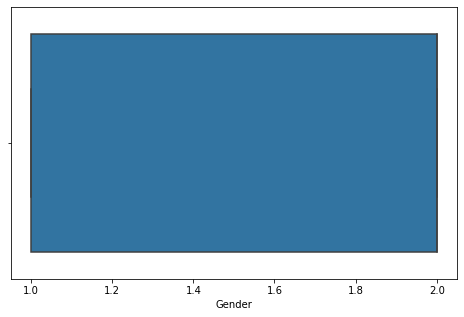

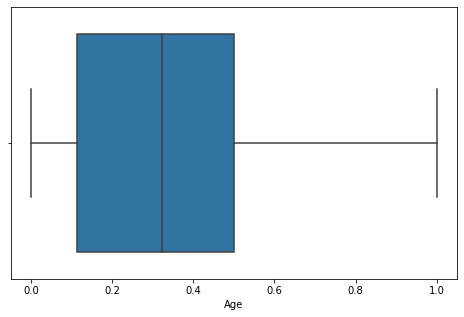

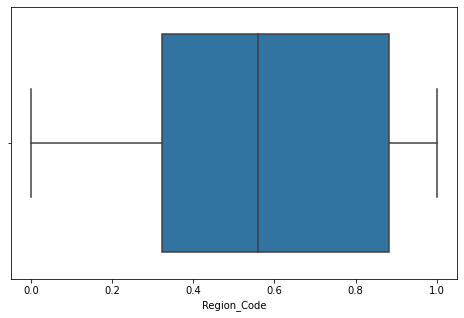

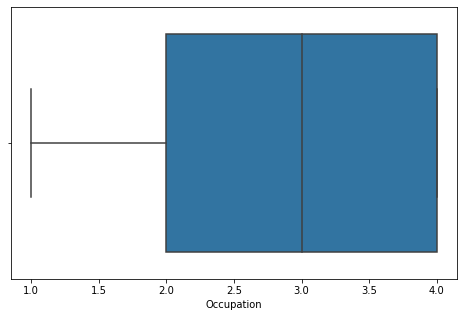

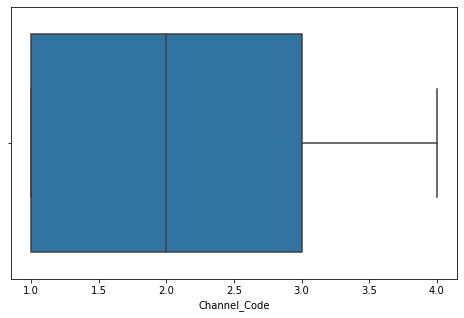

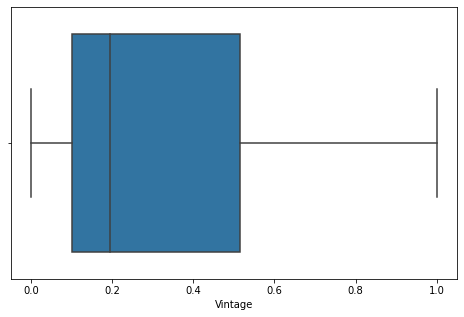

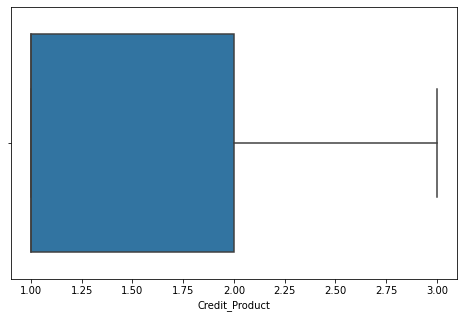

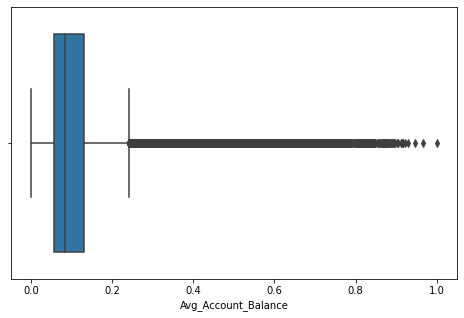

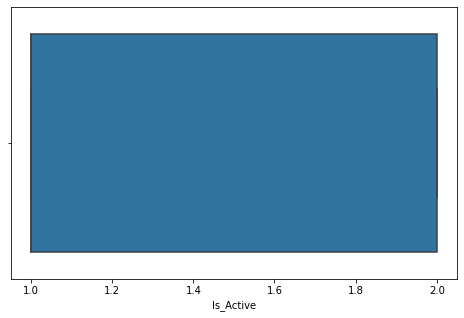

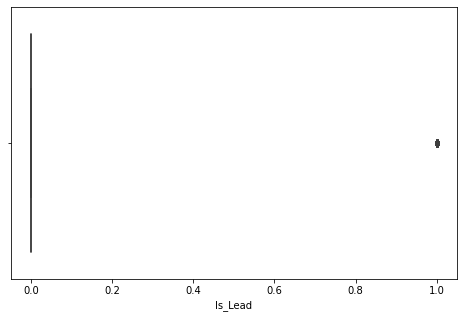

In [ ]:

for i in X_train_norm.select_dtypes(exclude = "object").columns:
  print(i)
  plt.figure(figsize=(8,5))
  sns.boxplot(i,data=X_train_norm)

In [ ]:
#df_train.Avg_Account_Balance.describe()
perc =[.20, .40, .60, .80, .90, .95,.99]
df_test.describe(percentiles = perc)

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
count,105312.000000,105312.000000,105312.000000,105312.000000,105312.000000,105312.000000,105312.000000,105312.000000,105312.000000
mean,1.547943,0.336629,0.583224,3.103587,1.900781,0.311272,1.533899,0.107771,1.394210
std,0.497698,0.239885,0.320699,0.852286,0.883744,0.252138,0.697612,0.083847,0.488683
min,1.000000,0.016129,0.000000,1.000000,1.000000,0.000000,1.000000,0.000175,1.000000
20%,1.000000,0.096774,0.205882,2.000000,1.000000,0.093750,1.000000,0.051239,1.000000
40%,1.000000,0.209677,0.529412,3.000000,1.000000,0.156250,1.000000,0.072470,1.000000
50%,2.000000,0.322581,0.558824,3.000000,2.000000,0.195312,1.000000,0.084776,1.000000
60%,2.000000,0.387097,0.705882,4.000000,2.000000,0.296875,2.000000,0.099514,1.000000
80%,2.000000,0.532258,0.941176,4.000000,3.000000,0.578125,2.000000,0.146253,2.000000
90%,2.000000,0.677419,0.970588,4.000000,3.000000,0.710938,3.000000,0.197100,2.000000


In [ ]:
# df_test.Credit_Product.value_counts()
# X_train_norm['Credit_Product'] = X_train_norm['Credit_Product'].fillna(X_train_norm['Credit_Product'].mode()[0])
# X_test_norm['Credit_Product'] = X_test_norm['Credit_Product'].fillna(X_test_norm['Credit_Product'].mode()[0])
X_train_norm['Credit_Product'].fillna(4,inplace=True)
X_test_norm['Credit_Product'].fillna(4,inplace=True)

In [ ]:
X=X_train_norm.drop(['Is_Lead','ID'],axis=1)
y=X_train_norm[['Is_Lead']]

In [ ]:
oversample = SMOTE()
# oversample=RandomUnderSampler()
X, y = oversample.fit_resample(X, y)
neg,pos=X_train_norm[['Is_Lead']].value_counts()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [ ]:
X=pd.DataFrame(X)
y=pd.DataFrame(y)
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.25,stratify=y)

In [ ]:

clf=RandomForestClassifier(n_estimators=50)
clf.fit(train_x,train_y)
y_pred=clf.predict(train_x)
y_pred_valid=clf.predict(valid_x)
print(sklearn.metrics.roc_auc_score(train_y, y_pred))
print(sklearn.metrics.classification_report(train_y, y_pred))
print(sklearn.metrics.roc_auc_score(valid_y, y_pred_valid))
print(sklearn.metrics.classification_report(valid_y, y_pred_valid))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.9984174460966492
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93718
           1       1.00      1.00      1.00     29144

    accuracy                           1.00    122862
   macro avg       1.00      1.00      1.00    122862
weighted avg       1.00      1.00      1.00    122862

0.755630076519884
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     93719
           1       0.75      0.57      0.65     29144

    accuracy                           0.85    122863
   macro avg       0.81      0.76      0.78    122863
weighted avg       0.85      0.85      0.85    122863



In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
MLPC = MLPClassifier(hidden_layer_sizes=(200,), max_iter=10000)
MLPC.fit(train_x, train_y)
y_pred=MLPC.predict(train_x)
y_pred_valid=MLPC.predict(valid_x)
print(sklearn.metrics.roc_auc_score(train_y, y_pred))
print(sklearn.metrics.classification_report(train_y, y_pred))
print(sklearn.metrics.roc_auc_score(valid_y, y_pred_valid))
print(sklearn.metrics.classification_report(valid_y, y_pred_valid))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.753359483971682
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     93718
           1       0.80      0.55      0.65     29144

    accuracy                           0.86    122862
   macro avg       0.84      0.75      0.78    122862
weighted avg       0.85      0.86      0.85    122862

0.7536823471014884
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     93719
           1       0.79      0.55      0.65     29144

    accuracy                           0.86    122863
   macro avg       0.83      0.75      0.78    122863
weighted avg       0.85      0.86      0.85    122863



In [ ]:
train_x.shape[1]

9

In [ ]:
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
model = Sequential()
model.add(Dense(1024, input_shape = (train_x.shape[1],), activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
sgd = optimizers.Adam(lr = 0.001)
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
model.fit(train_x, train_y.values, batch_size =128, epochs =100, verbose = 1)
best_model=model
new_preds = best_model.predict(train_x)
new_pred_labels = np.rint(new_preds)
print(sklearn.metrics.roc_auc_score(train_y, new_pred_labels))
print(sklearn.metrics.classification_report(train_y, new_pred_labels))
new_preds = best_model.predict(valid_x)
new_pred_labels = np.rint(new_preds)
print(sklearn.metrics.roc_auc_score(valid_y, new_pred_labels))
print(sklearn.metrics.classification_report(valid_y, new_pred_labels))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/100
2197/2197 [==============================] - 56s 25ms/step - loss: 0.4753 - auc_29: 0.8513
Epoch 2/100
2197/2197 [==============================] - 55s 25ms/step - loss: 0.4612 - auc_29: 0.8600
Epoch 3/100
2197/2197 [==============================] - 55s 25ms/step - loss: 0.4555 - auc_29: 0.8634
Epoch 4/100
2197/2197 [==============================] - 54s 25ms/step - loss: 0.4512 - auc_29: 0.8654
Epoch 5/100
2197/2197 [==============================] - 55s 25ms/step - loss: 0.4469 - auc_29: 0.8675
Epoch 6/100
2197/2197 [==============================] - 54s 25ms/step - loss: 0.4455 - auc_29: 0.8682
Epoch 7/100
2197/2197 [==============================] - 54s 25ms/step - loss: 0.4441 - auc_29: 0.8691
Epoch 8/100
2197/2197 [==============================] - 55s 25ms/step - loss: 0.4430 - auc_29: 0.8695
Epoch 9/100
2197/2197 [==============================] - 55s 25ms/step - loss: 0.4426 - auc_29: 0.8696
Epoch 10/100
2197/2197 [==============================] - 54s 25ms/step -

KeyboardInterrupt: ignored

In [ ]:
X_test_norm1=X_test_norm.drop(['ID'],axis=1)
test_preds = np.rint(best_model.predict(X_test_norm1))
test_pred=pd.DataFrame(test_preds)
test_pred.value_counts()

0.0    73012
1.0    32300
dtype: int64

In [ ]:

dtrain = lgb.Dataset(train_x, label=train_y)
dvalid = lgb.Dataset(valid_x, label=valid_y)

In [ ]:
class Objective:

    def __init__(self):
        self.best_booster = None
        self._booster = None

    def __call__(self, trial):
        param = {
            "objective": "binary",
            "metric": "auc",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "bagging_fraction": trial.suggest_loguniform("bagging_fraction", 0.01, 1.0),
            # "feature_fraction": trial.suggest_loguniform("feature_fraction", 0.01, 1.0),
            "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 0.01, 1.0),
            "max_depth": -1,
            "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
            "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
            "num_leaves": trial.suggest_int("num_leaves", 2, 200),
            "num_iterations": trial.suggest_int("num_iterations", 20, 1000),
            "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 20, 100),
            "learning_rate":trial.suggest_loguniform("learning_rate", 0.01, 1.0),
            "n_estimators": trial.suggest_int("n_estimators", 10, 1000)
            ,
            "scale_pos_weight" : train_y.size/train_y.where(train_y==0).dropna().size-1
        }

        # Add a callback for pruning.
        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")
        gbm = lgb.train(
            param, dtrain, valid_sets=[dvalid], verbose_eval=False, callbacks=[pruning_callback]
        )

        self._booster = gbm

        preds = gbm.predict(valid_x)
        pred_labels = np.rint(preds)
        accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
        return accuracy

    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_booster = self._booster

In [ ]:
objective = Objective()

study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="maximize"
)
study.optimize(objective, n_trials=100, callbacks=[objective.callback])

print("Best trial:")
trial = study.best_trial

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_model = objective.best_booster

new_preds = best_model.predict(train_x)
new_pred_labels = np.rint(new_preds)
print(sklearn.metrics.roc_auc_score(train_y, new_pred_labels))
print(sklearn.metrics.classification_report(train_y, new_pred_labels))
new_preds = best_model.predict(valid_x)
new_pred_labels = np.rint(new_preds)
print(sklearn.metrics.roc_auc_score(valid_y, new_pred_labels))
print(sklearn.metrics.classification_report(valid_y, new_pred_labels))

[I 2021-05-30 06:50:51,760] A new study created in memory with name: no-name-e6b974d4-775a-4979-9cc9-7a462087a7be
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

[I 2021-05-30 06:50:55,044] Trial 0 finished with value: 0.8556685088269048 and parameters: {'bagging_fraction': 0.10630042644762501, 'min_gain_to_split': 0.029965254842991732, 'lambda_l1': 0.20823790314129825, 'lambda_l2': 0.0007619274172190505, 'num_leaves': 26, 'num_iterations': 283, 'early_stopping_rounds': 90, 'learning_rate': 0.23895909999845208, 'n_estimators': 845}. Best is trial 0 with value: 0.8556685088269048.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3

Best trial:
  Params: 
    bagging_fraction: 0.12662479766833926
    min_gain_to_split: 0.030464234692411756
    lambda_l1: 2.239568718793956e-05
    lambda_l2: 0.00023743417157968223
    num_leaves: 35
    num_iterations: 170
    early_stopping_rounds: 84
    learning_rate: 0.22805917008732526
    n_estimators: 867
0.7245402188688586
              precision    recall  f1-score   support

           0       0.86      0.98      0.91     93718
           1       0.87      0.47      0.61     29144

    accuracy                           0.86    122862
   macro avg       0.86      0.72      0.76    122862
weighted avg       0.86      0.86      0.84    122862

0.723896256458027
              precision    recall  f1-score   support

           0       0.86      0.98      0.91     93719
           1       0.86      0.47      0.61     29144

    accuracy                           0.86    122863
   macro avg       0.86      0.72      0.76    122863
weighted avg       0.86      0.86      0.84   

In [ ]:
X_test_norm1=X_test_norm.drop(['ID','Credit_Product'],axis=1)
test_preds = np.rint(best_model.predict(X_test_norm1))
test_pred=pd.DataFrame(test_preds)
test_pred.value_counts()

0.0    103355
1.0      1957
dtype: int64

In [ ]:
gbm = lgb.train(
             train_set=dtrain, valid_sets=[dvalid], verbose_eval=False \
             ,params={}, num_boost_round=1000
        )

In [ ]:
new_preds = gbm.predict(train_x)
new_pred_labels = np.rint(new_preds)
print(sklearn.metrics.accuracy_score(train_y, new_pred_labels))
print(sklearn.metrics.classification_report(train_y, new_pred_labels))
new_preds = gbm.predict(valid_x)
new_pred_labels = np.rint(new_preds)
print(sklearn.metrics.accuracy_score(valid_y, new_pred_labels))
print(sklearn.metrics.classification_report(valid_y, new_pred_labels))

0.8800281383897167
              precision    recall  f1-score   support

           0       0.89      0.97      0.92    131206
           1       0.85      0.60      0.70     40801

    accuracy                           0.88    172007
   macro avg       0.87      0.78      0.81    172007
weighted avg       0.88      0.88      0.87    172007

0.859762880164953
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     56231
           1       0.79      0.55      0.65     17487

    accuracy                           0.86     73718
   macro avg       0.83      0.75      0.78     73718
weighted avg       0.85      0.86      0.85     73718



In [ ]:
ID=pd.DataFrame(X_test_norm.ID.astype(object))
lead= pd.DataFrame(test_pred.astype(int))
test_df=pd.concat([ID,lead],axis=1)
test_df.columns=['ID','Is_Lead']
test_df=test_df
# test_df=pd.DataFrame([X_test_norm.ID.astype(object),test_pred.astype(int)],index=['ID','Is_Lead']).T

In [ ]:
test_df.head(2)

,ID,Is_Lead
0,VBENBARO,0
1,CCMEWNKY,1


In [ ]:
test_df.to_csv('jobathon_Submission.csv',index=False)
from google.colab import files
files.download('jobathon_Submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>